# Installs & Imports

In [1]:
!pip install -q gpytorch botorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.8/277.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.8/644.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 2.3 MB/s eta 0:00:00


In [34]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch
import gpytorch
from gpytorch.likelihoods import GaussianLikelihood

from botorch.fit import fit_gpytorch_mll
from botorch.models import SingleTaskGP
from botorch.acquisition import qLogExpectedImprovement
from botorch.optim import optimize_acqf

import warnings
warnings.filterwarnings("ignore")

# Set a style for plots
sns.set(style="whitegrid")

# Data Loading

In [3]:
def load_diabetes_data():
    """
    Load the Diabetes dataset from sklearn.

    Returns:
        X (np.ndarray): Feature matrix.
        y (np.ndarray): Target vector.
        feature_names (List[str]): List of feature names.
    """
    data = load_diabetes()
    X = data.data
    y = data.target
    feature_names = data.feature_names
    return X, y, feature_names

In [4]:
# Load the data
X, y, feature_names = load_diabetes_data()

# Data Exploration

In [5]:
def explore_data(X, y, feature_names):
    """
    Perform exploratory data analysis on the Diabetes dataset.

    Args:
        X (np.ndarray): Feature matrix.
        y (np.ndarray): Target vector.
        feature_names (List[str]): List of feature names.
    """
    df = pd.DataFrame(X, columns=feature_names)
    df['target'] = y

    print("===== HEAD OF DATA =====")
    display(df.head())
    print("\n===== DESCRIPTIVE STATISTICS =====")
    display(df.describe())

    # Pairplot of first 3 features + target for clarity
    print("\n")
    subset_feats = feature_names[:3]
    sns.pairplot(df[subset_feats + ['target']], diag_kind='kde')
    plt.suptitle("Pair Plot of Selected Features", y=1.02)
    plt.show()

    # Correlation Heatmap
    print("\n")
    plt.figure(figsize=(10, 6))
    corr = df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title("Correlation Heatmap")
    plt.show()

    # Distribution of target
    print("\n")
    plt.figure()
    sns.histplot(y, kde=True)
    plt.title("Distribution of the Diabetes Target")
    plt.show()

===== HEAD OF DATA =====


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0



===== DESCRIPTIVE STATISTICS =====


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-2.511817e-19,1.230790e-17,-2.245564e-16,-4.797570e-17,-1.381499e-17,3.918434e-17,-5.777179e-18,-9.042540e-18,9.293722e-17,1.130318e-17,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123988e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260971e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665608e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324559e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670422e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947171e-03,-1.077698e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564379e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243232e-02,2.791705e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320436e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335973e-01,1.356118e-01,346.000000


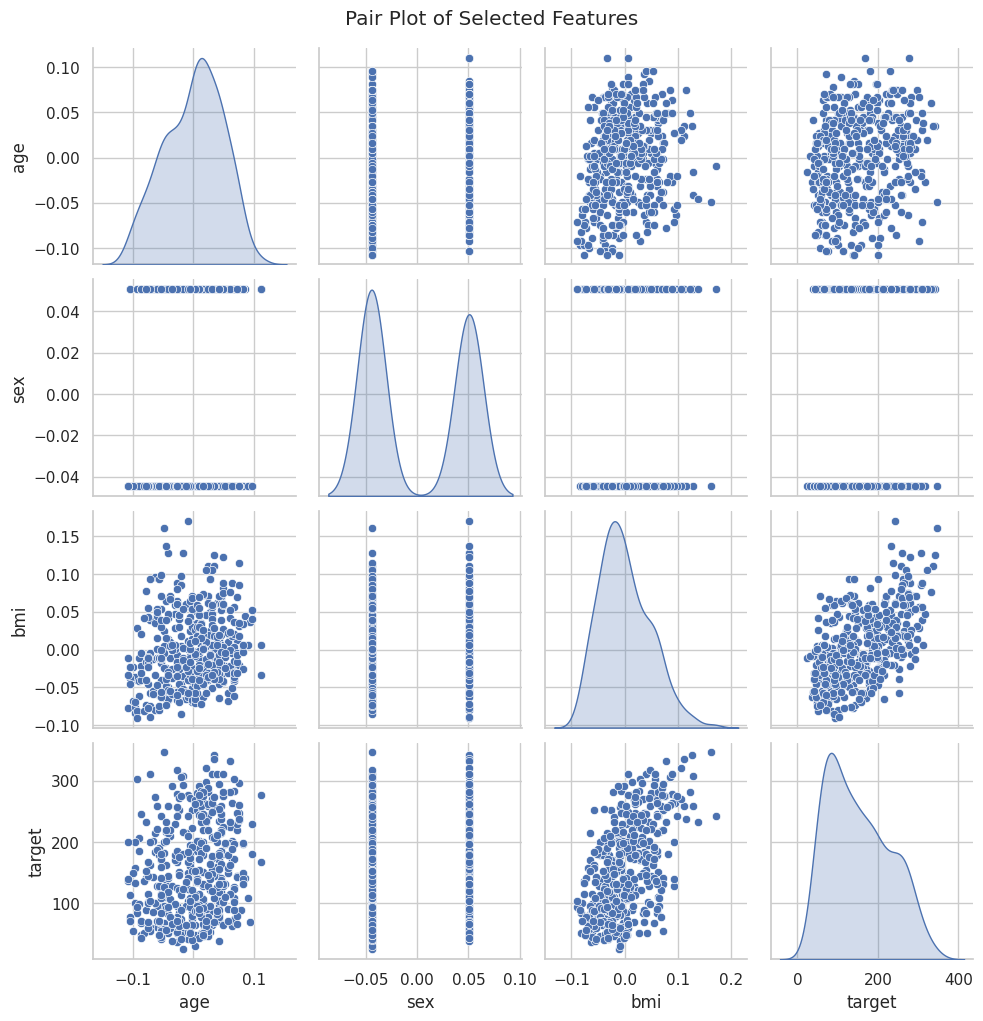

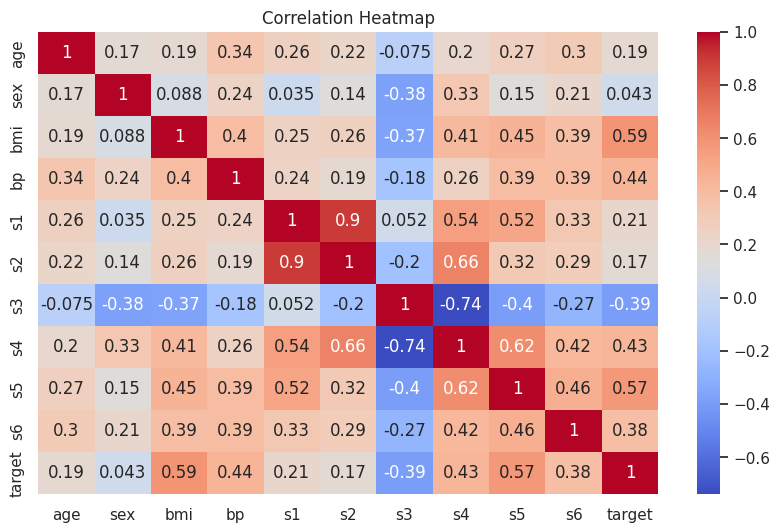

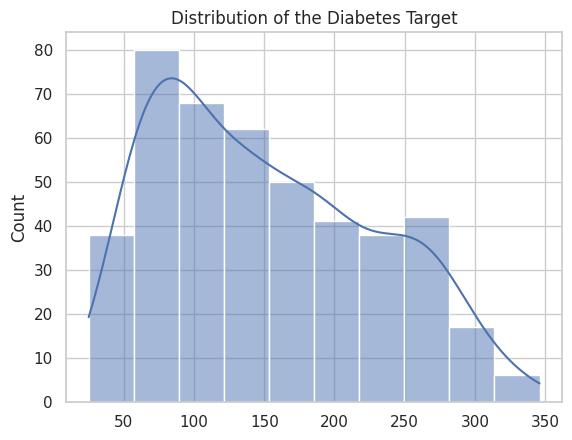

In [6]:
# Explore the data
explore_data(X, y, feature_names)

# Data Preparation

In [7]:
def preprocess_data(X, y, test_size=0.2, random_state=42):
    """
    Split the data into training and testing sets, apply min-max scaling,
    and convert to double precision.

    Args:
        X (np.ndarray): Feature matrix.
        y (np.ndarray): Target vector.
        test_size (float): Proportion of the dataset to include in the test split.
        random_state (int): Controls the shuffling applied to the data before applying the split.

    Returns:
        X_train (np.ndarray): Scaled training features.
        X_test (np.ndarray): Scaled testing features.
        y_train (np.ndarray): Training targets.
        y_test (np.ndarray): Testing targets.
    """
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train_raw)
    X_test = scaler.transform(X_test_raw)

    # Convert to double precision
    X_train = X_train.astype(np.float64)
    X_test = X_test.astype(np.float64)
    y_train = y_train.astype(np.float64)
    y_test = y_test.astype(np.float64)

    return X_train, X_test, y_train, y_test

In [8]:
# Preprocess the data
X_train, X_test, y_train, y_test = preprocess_data(X, y, test_size=0.2, random_state=42)
print(f"Train set size: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Test set size: X_test={X_test.shape}, y_test={y_test.shape}")

Train set size: X_train=(353, 10), y_train=(353,)
Test set size: X_test=(89, 10), y_test=(89,)


# Model Training

In [9]:
class ExactGPModel(gpytorch.models.ExactGP):
    """
    A standard Exact GP model using a Constant Mean and RBF kernel.
    """
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [10]:
def build_gpytorch_model(X_train, y_train):
    """
    Constructs an ExactGPModel and GaussianLikelihood from training data.

    Args:
        X_train (np.ndarray): Scaled training features.
        y_train (np.ndarray): Training targets.

    Returns:
        model (ExactGPModel): The GP model.
        likelihood (GaussianLikelihood): The likelihood.
    """
    # Convert data to torch tensors with double precision
    train_x_t = torch.tensor(X_train, dtype=torch.double)
    train_y_t = torch.tensor(y_train, dtype=torch.double)
    likelihood = GaussianLikelihood().double()
    model = ExactGPModel(train_x_t, train_y_t, likelihood)
    return model, likelihood

In [11]:
# class ExactGPModelMatern(gpytorch.models.ExactGP):
#     """
#     A GP model using a Matern kernel.
#     """
#     def __init__(self, train_x, train_y, likelihood):
#         super(ExactGPModelMatern, self).__init__(train_x, train_y, likelihood)
#         self.mean_module = gpytorch.means.ConstantMean()
#         self.covar_module = gpytorch.kernels.ScaleKernel(
#             gpytorch.kernels.MaternKernel(nu=2.5)
#         )

#     def forward(self, x):
#         mean_x = self.mean_module(x)
#         covar_x = self.covar_module(x)
#         return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [12]:
# def build_gpytorch_model_matern(X_train, y_train):
#     """
#     Constructs an ExactGPModelMatern and GaussianLikelihood from training data.

#     Args:
#         X_train (np.ndarray): Scaled training features.
#         y_train (np.ndarray): Training targets.

#     Returns:
#         model (ExactGPModelMatern): The GP model with Matern kernel.
#         likelihood (GaussianLikelihood): The likelihood.
#     """
#     # Convert data to torch tensors with double precision
#     train_x_t = torch.tensor(X_train, dtype=torch.double)
#     train_y_t = torch.tensor(y_train, dtype=torch.double)
#     likelihood = GaussianLikelihood().double()
#     model = ExactGPModelMatern(train_x_t, train_y_t, likelihood)
#     return model, likelihood

In [13]:
def train_gpytorch_model(model, likelihood, X_train, y_train, lr=0.01, max_iter=1000, verbose=False, patience=50):
    """
    Train the GP model using a custom training loop with the Adam optimizer,
    incorporating early stopping and gradient clipping.

    Args:
        model (ExactGPModel): The GP model to train.
        likelihood (GaussianLikelihood): The likelihood.
        X_train (np.ndarray): Scaled training features.
        y_train (np.ndarray): Training targets.
        lr (float): Learning rate for the optimizer.
        max_iter (int): Maximum number of training iterations.
        verbose (bool): If True, print loss at each iteration.
        patience (int): Number of iterations with no improvement after which training will be stopped.

    Returns:
        model (ExactGPModel): The trained GP model.
        likelihood (GaussianLikelihood): The trained likelihood.
    """
    model.train()
    likelihood.train()

    # Define the Marginal Log Likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    # Use the Adam optimizer with weight decay for regularization
    optimizer = torch.optim.Adam([
        {'params': model.parameters()},
    ], lr=lr, weight_decay=1e-6)

    best_loss = float('inf')
    no_improve = 0

    for i in range(1, max_iter + 1):
        optimizer.zero_grad()
        output = model(model.train_inputs[0])
        loss = -mll(output, model.train_targets)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        # Early Stopping
        if loss.item() < best_loss - 1e-4:
            best_loss = loss.item()
            no_improve = 0
        else:
            no_improve += 1

        if verbose and (i % max(1, max_iter // 10) == 0 or i == 1):
            print(f"Iter {i}/{max_iter} - Loss: {loss.item():.4f}")

        if no_improve >= patience:
            if verbose:
                print(f"Early stopping at iteration {i}")
            break

    return model, likelihood

In [14]:
# Build the untuned model
model_untuned, likelihood_untuned = build_gpytorch_model(X_train, y_train)

# Train the model
print("===== Training UNTUNED Model =====")
model_untuned, likelihood_untuned = train_gpytorch_model(
    model_untuned, likelihood_untuned,
    X_train, y_train,
    lr=0.1,
    max_iter=30000,
    verbose=True,
    patience=6000
)

===== Training UNTUNED Model =====
Iter 1/30000 - Loss: 2381.6189
Iter 3000/30000 - Loss: 12.5131
Iter 6000/30000 - Loss: 9.1872
Iter 9000/30000 - Loss: 7.6188
Iter 12000/30000 - Loss: 6.7731
Iter 15000/30000 - Loss: 6.3398
Iter 18000/30000 - Loss: 6.1586
Iter 21000/30000 - Loss: 6.0294
Iter 24000/30000 - Loss: 6.0185
Iter 27000/30000 - Loss: 6.0185
Early stopping at iteration 29295


# Model Evaluation

In [15]:
def evaluate_model(model, likelihood, X_test, y_test):
    """
    Evaluate the trained GP model on test data.

    Args:
        model (ExactGPModel): The trained GP model.
        likelihood (GaussianLikelihood): The trained likelihood.
        X_test (np.ndarray): Scaled testing features.
        y_test (np.ndarray): Testing targets.

    Returns:
        metrics (dict): Dictionary containing MSE, MAE, RMSE, R^2.
        predictions (np.ndarray): Predicted target values.
    """
    model.eval()
    likelihood.eval()

    # Convert test data to torch tensors with double precision
    test_x_t = torch.tensor(X_test, dtype=torch.double)
    test_y_t = torch.tensor(y_test, dtype=torch.double)

    with torch.no_grad():
        preds = likelihood(model(test_x_t))
        mean_preds = preds.mean.numpy()
        actuals = test_y_t.numpy()

    mse = np.mean((mean_preds - actuals)**2)
    mae = np.mean(np.abs(mean_preds - actuals))
    rmse = np.sqrt(mse)
    r2 = 1 - np.sum((mean_preds - actuals)**2) / np.sum((actuals - np.mean(actuals))**2)

    metrics = {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'R^2': r2
    }
    return metrics, mean_preds

In [16]:
# Evaluate the untuned model
untuned_metrics, untuned_preds = evaluate_model(model_untuned, likelihood_untuned, X_test, y_test)
print("===== UNTUNED Model Performance =====")
for metric, value in untuned_metrics.items():
    print(f"{metric}: {value:.4f}")

===== UNTUNED Model Performance =====
MSE: 2536.9302
MAE: 39.6479
RMSE: 50.3679
R^2: 0.5212


In [17]:
def plot_predictions(predictions, actuals, title_suffix=""):
    """
    Scatter plot of predicted vs. actual target values with a reference diagonal.

    Args:
        predictions (np.ndarray): Predicted target values.
        actuals (np.ndarray): Actual target values.
        title_suffix (str): Suffix to add to the plot title.
    """
    plt.figure(figsize=(6,6))
    plt.scatter(actuals, predictions, alpha=0.6, edgecolor='k')
    min_val, max_val = min(actuals), max(actuals)
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Fit')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Predicted vs. Actual Values {title_suffix}")
    plt.legend()
    plt.show()

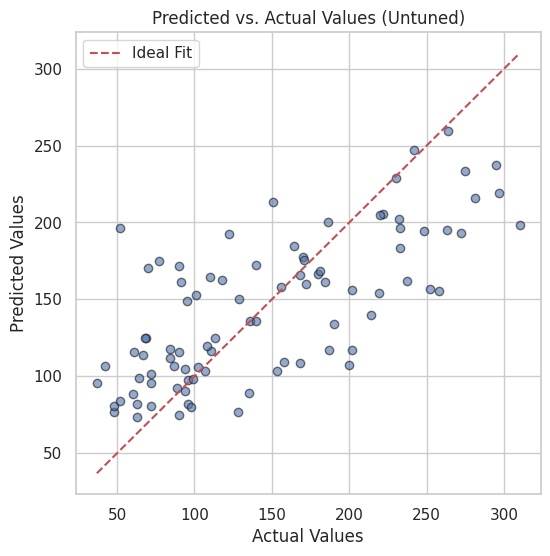

In [18]:
# Plot predictions
plot_predictions(untuned_preds, y_test, title_suffix="(Untuned)")

In [19]:
def evaluate_probabilistic_metrics(model, likelihood, X_test, y_test):
    """
    Evaluate probabilistic metrics of the GP model on test data.

    Args:
        model (ExactGPModel): The trained GP model.
        likelihood (GaussianLikelihood): The trained likelihood.
        X_test (np.ndarray): Scaled testing features.
        y_test (np.ndarray): Testing targets.

    Returns:
        metrics (dict): Dictionary containing Log Marginal Likelihood (LML),
                        Negative Log Predictive Density (NLPD), and Coverage Probability.
    """
    model.eval()
    likelihood.eval()

    # Convert test data to torch tensors with double precision
    test_x_t = torch.tensor(X_test, dtype=torch.double)
    test_y_t = torch.tensor(y_test, dtype=torch.double)

    with torch.no_grad():
        preds = likelihood(model(test_x_t))
        mean_preds = preds.mean
        lower, upper = preds.confidence_region()
        actuals = test_y_t

    # Log Marginal Likelihood (Sum over test points)
    lml = torch.sum(preds.log_prob(actuals)).item()

    # Negative Log Predictive Density (Sum over test points)
    nlpd = -torch.sum(torch.distributions.Normal(mean_preds, preds.variance.sqrt()).log_prob(actuals)).item()

    # Coverage Probability (e.g., 95% confidence interval)
    coverage = ((actuals >= lower) & (actuals <= upper)).float().mean().item()

    metrics = {
        'Log Marginal Likelihood': lml,
        'Negative Log Predictive Density': nlpd,
        'Coverage Probability (95%)': coverage
    }
    return metrics

In [20]:
# Evaluate probabilistic metrics
prob_metrics = evaluate_probabilistic_metrics(model_untuned, likelihood_untuned, X_test, y_test)
print("===== UNTUNED Model Probabilistic Metrics =====")
for metric, value in prob_metrics.items():
    print(f"{metric}: {value:.4f}")

===== UNTUNED Model Probabilistic Metrics =====
Log Marginal Likelihood: -499.2949
Negative Log Predictive Density: 499.6410
Coverage Probability (95%): 0.7978


# Hyperparameter Tuning

In [21]:
def objective_function(lr, num_iter, lengthscale, outputscale, noise):
    """
    Train a GP model with given hyperparameters and return the MSE on the test set.

    Args:
        lr (float): Learning rate for the optimizer.
        num_iter (int): Number of training iterations.
        lengthscale (float): Lengthscale parameter for the RBF kernel.
        outputscale (float): Outputscale parameter for the RBF kernel.
        noise (float): Noise variance for the GaussianLikelihood.

    Returns:
        mse (float): Mean Squared Error on the test set.
    """
    # Build a fresh model
    model_local, likelihood_local = build_gpytorch_model(X_train, y_train)

    # Set kernel hyperparameters
    with torch.no_grad():
        model_local.covar_module.base_kernel.lengthscale = torch.tensor(lengthscale, dtype=torch.double)
        model_local.covar_module.outputscale = torch.tensor(outputscale, dtype=torch.double)
        likelihood_local.noise = torch.tensor(noise, dtype=torch.double)

    # Train the model with specified hyperparameters
    model_local, likelihood_local = train_gpytorch_model(
        model_local, likelihood_local,
        X_train, y_train,
        lr=lr,
        max_iter=num_iter,
        verbose=False,
        patience=50
    )

    # Evaluate the model
    metrics_local, _ = evaluate_model(model_local, likelihood_local, X_test, y_test)
    return metrics_local['MSE']

In [22]:
# Number of initial random evaluations and BO iterations
N_INIT = 10
N_BO_ITER = 15

# Define the bounds for hyperparameters: [lr, num_iter, lengthscale, outputscale, noise]
bounds = torch.tensor([
    [1e-4,    50.,    0.1,    0.1,    1e-5],   # Lower bounds
    [1e-1, 100000.,    10.,    10.,    1e-1]   # Upper bounds
], dtype=torch.double)  # Shape: (2, 5)

print(f"Bounds shape: {bounds.shape}")  # Should output: torch.Size([2, 5])

Bounds shape: torch.Size([2, 5])


In [23]:
def evaluate_candidate(candidate):
    """
    Given a candidate hyperparameter quintuple, evaluate the objective function.

    Args:
        candidate (torch.Tensor): Tensor of shape (1, 5) containing [lr, num_iter, lengthscale, outputscale, noise].

    Returns:
        torch.Tensor: Tensor containing [-MSE] for maximization.
    """
    lr_val = candidate[0, 0].item()
    num_iter_val = int(round(candidate[0, 1].item()))
    lengthscale_val = candidate[0, 2].item()
    outputscale_val = candidate[0, 3].item()
    noise_val = candidate[0, 4].item()

    mse_val = objective_function(
        lr=lr_val,
        num_iter=num_iter_val,
        lengthscale=lengthscale_val,
        outputscale=outputscale_val,
        noise=noise_val
    )
    return torch.tensor([[-mse_val]], dtype=torch.double)  # Negative MSE for maximization

In [24]:
# Initialize training data with random samples
torch.manual_seed(42)
np.random.seed(42)

train_x_list = []
train_y_list = []

for _ in range(N_INIT):
    # Sample hyperparameters uniformly within the bounds
    lr_sample = 10 ** np.random.uniform(-4, -1)   # log-uniform for lr
    num_iter_sample = np.random.uniform(50, 300)  # Initially restrict num_iter
    lengthscale_sample = np.random.uniform(0.1, 10.0)
    outputscale_sample = np.random.uniform(0.1, 10.0)
    noise_sample = np.random.uniform(1e-5, 1e-1)

    mse_sample = objective_function(
        lr=lr_sample,
        num_iter=int(round(num_iter_sample)),
        lengthscale=lengthscale_sample,
        outputscale=outputscale_sample,
        noise=noise_sample
    )

    train_x_list.append([lr_sample, num_iter_sample, lengthscale_sample, outputscale_sample, noise_sample])
    train_y_list.append(-mse_sample)  # Store negative MSE for maximization

train_x = torch.tensor(train_x_list, dtype=torch.double)  # Shape: (N_INIT, 5)
train_y = torch.tensor(train_y_list, dtype=torch.double).unsqueeze(-1)  # Shape: (N_INIT, 1)

In [25]:
# Store BO results
results_bo = []

for i in range(N_BO_ITER):
    # Fit a SingleTaskGP model to the existing data
    gp = SingleTaskGP(train_x, train_y)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)

    # Define the acquisition function (qLogExpectedImprovement)
    EI = qLogExpectedImprovement(model=gp, best_f=train_y.max().item())

    # Optimize the acquisition function to get the next candidate
    try:
        candidate, acq_value = optimize_acqf(
            acq_function=EI,
            bounds=bounds,
            q=1,
            num_restarts=10,
            raw_samples=100,
            options={"batch_limit": 5, "maxiter": 200},
        )
    except Exception as e:
        print(f"Error during acquisition function optimization: {e}")
        break

    # Evaluate the new candidate
    new_y = evaluate_candidate(candidate)  # Returns -MSE
    new_x = candidate.detach()

    # Append the new data
    train_x = torch.cat([train_x, new_x], dim=0)
    train_y = torch.cat([train_y, new_y], dim=0)

    # Log the results
    lr_val = new_x[0, 0].item()
    num_iter_val = int(round(new_x[0, 1].item()))
    lengthscale_val = new_x[0, 2].item()
    outputscale_val = new_x[0, 3].item()
    noise_val = new_x[0, 4].item()
    mse_val = -new_y.item()  # Convert back to positive MSE
    results_bo.append({
        'Iteration': i+1,
        'lr': lr_val,
        'num_iter': num_iter_val,
        'lengthscale': lengthscale_val,
        'outputscale': outputscale_val,
        'noise': noise_val,
        'MSE': mse_val
    })
    print(f"[BO] Iter {i+1}/{N_BO_ITER}: lr={lr_val:.6f}, num_iter={num_iter_val}, lengthscale={lengthscale_val:.4f}, outputscale={outputscale_val:.4f}, noise={noise_val:.6f}, MSE={mse_val:.4f}")

[BO] Iter 1/15: lr=0.063284, num_iter=87408, lengthscale=7.1402, outputscale=7.3033, noise=0.031933, MSE=2536.3388
[BO] Iter 2/15: lr=0.073694, num_iter=24881, lengthscale=0.2901, outputscale=8.5624, noise=0.077098, MSE=2535.7482
[BO] Iter 3/15: lr=0.022014, num_iter=12047, lengthscale=3.5291, outputscale=0.6288, noise=0.004326, MSE=2966.1447
[BO] Iter 4/15: lr=0.056768, num_iter=26029, lengthscale=9.8176, outputscale=4.7964, noise=0.097227, MSE=2522.1965
[BO] Iter 5/15: lr=0.026000, num_iter=33748, lengthscale=1.8598, outputscale=2.0801, noise=0.094823, MSE=2816.0217
[BO] Iter 6/15: lr=0.070333, num_iter=20070, lengthscale=7.3049, outputscale=1.4339, noise=0.044045, MSE=2747.2117
[BO] Iter 7/15: lr=0.008080, num_iter=8742, lengthscale=7.8703, outputscale=2.2212, noise=0.054243, MSE=2715.5535
[BO] Iter 8/15: lr=0.056877, num_iter=83023, lengthscale=5.7139, outputscale=1.3834, noise=0.076287, MSE=2536.5108
[BO] Iter 9/15: lr=0.046885, num_iter=94366, lengthscale=4.5679, outputscale=1.11

In [26]:
# Convert BO results to DataFrame
bo_df = pd.DataFrame(results_bo)
print("===== Bayesian Optimization Results =====")
display(bo_df)

# Find the best hyperparameters
if not bo_df.empty:
    best_row = bo_df.loc[bo_df['MSE'].idxmin()]
    best_lr = best_row['lr']
    best_num_iter = best_row['num_iter']
    best_lengthscale = best_row['lengthscale']
    best_outputscale = best_row['outputscale']
    best_noise = best_row['noise']
    best_mse = best_row['MSE']

    print(f"\nBest Hyperparameters Found:\n"
          f"lr={best_lr:.6f}, num_iter={best_num_iter}, "
          f"lengthscale={best_lengthscale:.4f}, outputscale={best_outputscale:.4f}, "
          f"noise={best_noise:.6f}, MSE={best_mse:.4f}")
else:
    print("No valid BO iterations were completed.")

===== Bayesian Optimization Results =====


,Iteration,lr,num_iter,lengthscale,outputscale,noise,MSE
0,1,0.063284,87408,7.140201,7.303261,0.031933,2536.338809
1,2,0.073694,24881,0.290059,8.562446,0.077098,2535.748188
2,3,0.022014,12047,3.529116,0.628810,0.004326,2966.144736
3,4,0.056768,26029,9.817615,4.796418,0.097227,2522.196488
4,5,0.026000,33748,1.859818,2.080074,0.094823,2816.021666
5,6,0.070333,20070,7.304907,1.433887,0.044045,2747.211711
6,7,0.008080,8742,7.870321,2.221182,0.054243,2715.553477
7,8,0.056877,83023,5.713943,1.383437,0.076287,2536.510793
8,9,0.046885,94366,4.567917,1.113282,0.057414,2536.333530
9,10,0.074542,14026,9.740741,7.106155,0.014886,2960.276923



Best Hyperparameters Found:
lr=0.056768, num_iter=26029.0, lengthscale=9.8176, outputscale=4.7964, noise=0.097227, MSE=2522.1965


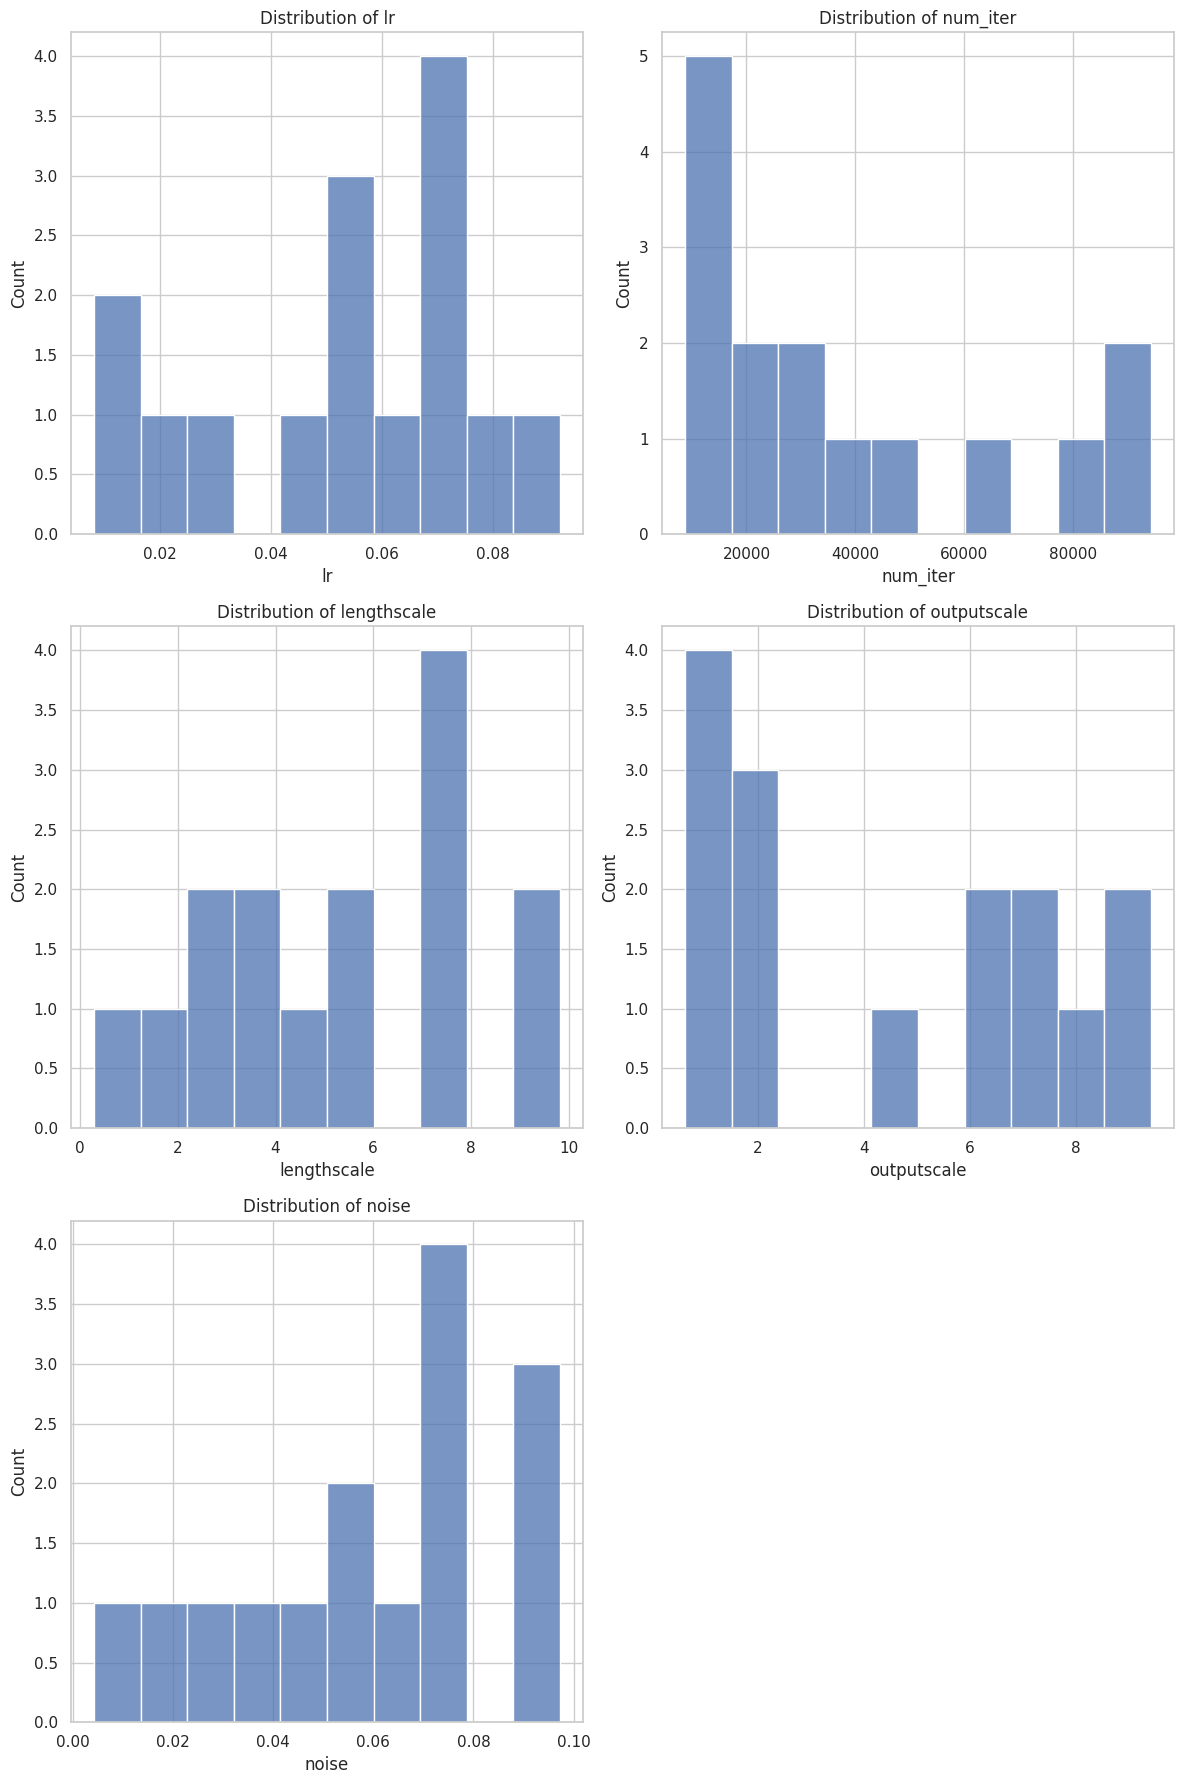

In [35]:
# Plot distributions of each hyperparameter
hyperparams = ['lr', 'num_iter', 'lengthscale', 'outputscale', 'noise']

# Number of hyperparameters
num_params = len(hyperparams)

# Calculate number of rows and columns (e.g., 2 columns)
cols = 2
rows = math.ceil(num_params / cols)

fig, axes = plt.subplots(rows, cols, figsize=(12, 6 * rows))
axes = axes.flatten()

for i, param in enumerate(hyperparams):
    sns.histplot(bo_df[param], bins=10, ax=axes[i])
    axes[i].set_title(f"Distribution of {param}")

# Hide any unused subplots
for j in range(num_params, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Model Re-Training

In [28]:
# Retrain the model with the best hyperparameters
print("===== Retraining with Tuned Hyperparameters =====")
model_tuned, likelihood_tuned = build_gpytorch_model(X_train, y_train)

# Set the best hyperparameters
with torch.no_grad():
    model_tuned.covar_module.base_kernel.lengthscale = torch.tensor(best_lengthscale, dtype=torch.double)
    model_tuned.covar_module.outputscale = torch.tensor(best_outputscale, dtype=torch.double)
    likelihood_tuned.noise = torch.tensor(best_noise, dtype=torch.double)

# Train the model
model_tuned, likelihood_tuned = train_gpytorch_model(
    model_tuned, likelihood_tuned,
    X_train, y_train,
    lr=best_lr,
    max_iter=int(best_num_iter),
    verbose=True,
    patience=6000
)

===== Retraining with Tuned Hyperparameters =====
Iter 1/26029 - Loss: 16094.5567
Iter 2602/26029 - Loss: 16.3519
Iter 5204/26029 - Loss: 11.8329
Iter 7806/26029 - Loss: 9.5498
Iter 10408/26029 - Loss: 8.1749
Iter 13010/26029 - Loss: 7.3263
Iter 15612/26029 - Loss: 6.7988
Iter 18214/26029 - Loss: 6.4681
Iter 20816/26029 - Loss: 6.2729
Iter 23418/26029 - Loss: 6.1760
Iter 26020/26029 - Loss: 6.0733


# Model Re-Evaluation

In [29]:
# Evaluate the tuned model
tuned_metrics, tuned_preds = evaluate_model(model_tuned, likelihood_tuned, X_test, y_test)
print("===== Tuned Model Performance =====")
for metric, value in tuned_metrics.items():
    print(f"{metric}: {value:.4f}")

===== Tuned Model Performance =====
MSE: 2522.1965
MAE: 39.4222
RMSE: 50.2215
R^2: 0.5239


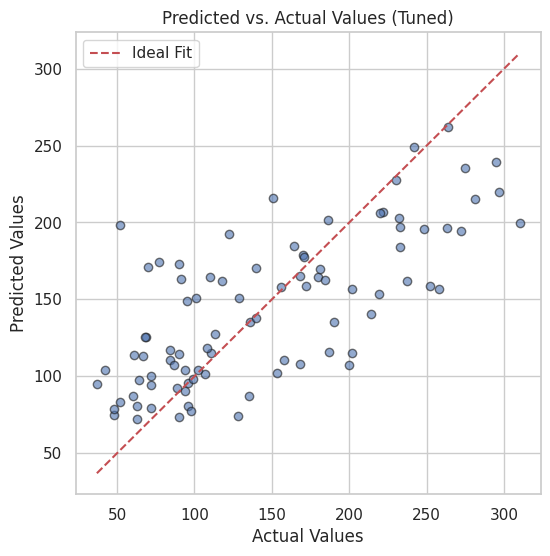

In [30]:
# Plot predictions for tuned model
plot_predictions(tuned_preds, y_test, title_suffix="(Tuned)")

In [31]:
# Evaluate probabilistic metrics
prob_metrics_tuned = evaluate_probabilistic_metrics(model_tuned, likelihood_tuned, X_test, y_test)
print("===== Tuned Model Probabilistic Metrics =====")
for metric, value in prob_metrics_tuned.items():
    print(f"{metric}: {value:.4f}")

===== Tuned Model Probabilistic Metrics =====
Log Marginal Likelihood: -502.9624
Negative Log Predictive Density: 502.9207
Coverage Probability (95%): 0.7753


# Results Comparison

In [37]:
# Compare Untuned vs. Tuned Models
comparison_df = pd.DataFrame({
    'Model': ['Untuned', 'Tuned'],
    'MSE':  [untuned_metrics['MSE'],  tuned_metrics['MSE']],
    'MAE':  [untuned_metrics['MAE'],  tuned_metrics['MAE']],
    'RMSE': [untuned_metrics['RMSE'], tuned_metrics['RMSE']],
    'R^2':  [untuned_metrics['R^2'],  tuned_metrics['R^2']],
    'Log ML': [prob_metrics['Log Marginal Likelihood'], prob_metrics_tuned['Log Marginal Likelihood']],
    'NLPD': [prob_metrics['Negative Log Predictive Density'], prob_metrics_tuned['Negative Log Predictive Density']],
    'CP(95%)': [prob_metrics['Coverage Probability (95%)'], prob_metrics_tuned['Coverage Probability (95%)']]
})

print("===== Comparison: Untuned vs. Tuned =====")
display(comparison_df)

===== Comparison: Untuned vs. Tuned =====


,Model,MSE,MAE,RMSE,R^2,Log ML,NLPD,CP(95%)
0,Untuned,2536.930154,39.647942,50.367948,0.521167,-499.294854,499.641012,0.797753
1,Tuned,2522.196488,39.422243,50.221474,0.523948,-502.962395,502.920670,0.775281


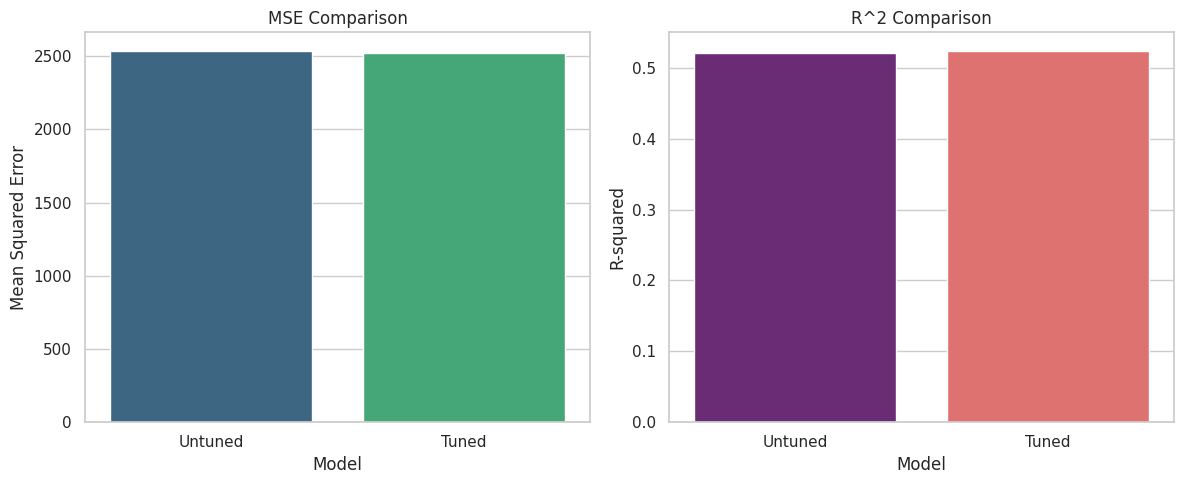

In [33]:
# Visualization of Comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# MSE Comparison
sns.barplot(data=comparison_df, x='Model', y='MSE', ax=axes[0], palette='viridis')
axes[0].set_title("MSE Comparison")
axes[0].set_ylabel("Mean Squared Error")

# R^2 Comparison
sns.barplot(data=comparison_df, x='Model', y='R^2', ax=axes[1], palette='magma')
axes[1].set_title("R^2 Comparison")
axes[1].set_ylabel("R-squared")

plt.tight_layout()
plt.show()